## Using the Keras Framework with Covnets

This notebook details the work done on a flowers dataset.  It consists of 6500 images across 102 classes.  The dataset comes from the Facebook udacity challenge.  The aim of this notebook is to investigate how the use the Keras Framework can be used to efficiently carry out analysis of a (smaller) dataset of images.

This work refernces the following sources:
- `http://blog.udacity.com/2018/10/introducing-the-pytorch-scholarship-challenge-from-facebook.html`
- `http://machinelearningmastery.com/crash-course-convolutional-neural-networks/`
- `http://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720`
- `http://www.manning.com/books/deep-learning-with-python`



In [1]:
import os, shutil
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline 
from keras.preprocessing import image

C:\Users\richard\Anaconda3\envs\tf15\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### The Data
The data consists of 102 classes of flowers.  The training data consists of 6552 images whilst the validation consits of 818.  Some of the classes are very unbalanced for example Class 1 has 27 images whereas Class 43 has 81 images.  Further work could be done on this class imbalance, but this work will not be utilsed here.  The images are generally of the size 667 x 500 pixels.

In [2]:
# The directory to store the dataset
base_dir = 'D:\\ml_code\\keras\\flower_data'
#os.mkdir(base_dir)
# Directories for our training,
# validation and test splits
train_dir = 'D:\\ml_code\\keras\\flower_data\\train'
#os.mkdir(train_dir)
validation_dir = 'D:\\ml_code\\keras\\flower_data\\valid'

In [3]:
train_count = sum([len(files) for r, d, files in os.walk(train_dir)])
valid_count = sum([len(files) for r, d, files in os.walk(validation_dir)])
print("number of training count images across 102 classes:", train_count )
print("number of validation count images across 102 classes:", valid_count )

number of training count images across 104 classes: 6552
number of validation count images across 104 classes: 818


### Build the Model

Here we use the general structure suggested by Choillet. The convnet will be a stack of alternated `Conv2D` (with `relu` activation) and `MaxPooling2D` layers.

Since dealing with a more complex problem, make the network accordingly larger: it will have one 
more `Conv2D` + `MaxPooling2D` stage. This serves both to augment the capacity of the network, and to further reduce the size of the 
feature maps, so that they aren't overly large when we reach the `Flatten` layer. Here, since we start from inputs of size 300x300 we end up with feature maps of size 16x16 right before the `Flatten` layer.

The images will be processed as 300 x 300 pixels wide, an arbitrary choice.

Note that the depth of the feature maps is progressively increasing in the network (from 32 to 128), while the size of the feature maps is 
decreasing (from 148x148 to 16x16). This is a pattern that you will see in almost all convnets.

Since we are attacking a multiclass classification problem, we are ending the network with a single unit (a `Dense` layer of size 102) and a 
`softmax` activation. This unit will encode the probability that the network is looking for several classes

In [33]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(300, 300, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(102, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 33, 33, 128)       147584    
__________

For our compilation step, we'll go with the `RMSprop` optimizer. Since we ended our network with a softmax unit, we will 
use categorical crossentropy as our loss.

In [34]:
from keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

Possible Last layer activation and loss function for model

Problem Type  | Last-layer activation | Loss function  
------------- | --------------------- | ---------------  
Binary        | Sigmoid               | binary_crossentropy
Multiclass, single-label  | softmax   | categorical_crossentropy
Multiclass, multi-label        | Sigmoid               | binary_crossentropy
Regression to arbitrary values  | None   | mse
Regression to values between 0 and 1  | None   | mse or binary_crossentropy

### Data preprocessing
The steps for getting it into the network:

* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval.

Keras has a module with image processing helper tools, located at `keras.preprocessing.image`. In particular, it contains the class `ImageDataGenerator` which allows to 
quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors.

Tutorial on keras `flow_to_directory` using python generators

- `https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720`

In [48]:
from keras.preprocessing.image import ImageDataGenerator

#scale all images by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 300x300
        target_size=(300, 300),
        #processing as colour images
        color_mode = 'rgb',
        batch_size=40,
        # use categorical_crossentropy loss
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(300, 300),
        color_mode = 'rgb',
        batch_size=40,
        class_mode='categorical')

Found 6552 images belonging to 102 classes.
Found 818 images belonging to 102 classes.


The generator yields batches of 300x300 RGB images (shape `(40, 300, 300, 3)`) and multi 
labels (shape `(40,102)`). 40 is the number of samples in each batch (the batch size). Note that the generator yields these batches 
indefinitely: it just loops endlessly over the images present in the target folder. For this reason, we need to `break` the iteration loop 
at some point.

In [50]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (40, 300, 300, 3)
labels batch shape: (40, 102)


Fit our model to the data using the generator. We do it using the `fit_generator` method, the equivalent of `fit` for data generators 
like ours. It expects as first argument a Python generator that will yield batches of inputs and targets indefinitely, like ours does. 
Because the data is being generated endlessly, the generator needs to know example how many samples to draw from the generator before 
declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the 
generator, i.e. after having run for `steps_per_epoch` gradient descent steps, the fitting process will go to the next epoch. In our case, 
batches are 40-sample large, so it will take 70 batches until we see our target of 7000 samples.

When using `fit_generator`, one may pass a `validation_data` argument, much like with the `fit` method. Importantly, this argument is 
allowed to be a data generator itself, but it could be a tuple of Numpy arrays as well. If you pass a generator as `validation_data`, then 
this generator is expected to yield batches of validation data endlessly, and thus you should also specify the `validation_steps` argument, 
which tells the process how many batches to draw from the validation generator for evaluation.

In [37]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=70,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
70/70 [==============================] - 29s 407ms/step - loss: 4.4816 - acc: 0.0368 - val_loss: 4.2797 - val_acc: 0.0736
Epoch 2/30
70/70 [==============================] - 28s 397ms/step - loss: 4.1258 - acc: 0.0768 - val_loss: 3.8950 - val_acc: 0.1017
Epoch 3/30
70/70 [==============================] - 28s 393ms/step - loss: 3.6656 - acc: 0.1449 - val_loss: 3.5720 - val_acc: 0.1641
Epoch 4/30
70/70 [==============================] - 28s 399ms/step - loss: 3.3489 - acc: 0.2004 - val_loss: 3.3068 - val_acc: 0.1989
Epoch 5/30
70/70 [==============================] - 28s 402ms/step - loss: 3.1017 - acc: 0.2411 - val_loss: 3.0946 - val_acc: 0.2485
Epoch 6/30
70/70 [==============================] - 27s 393ms/step - loss: 2.8036 - acc: 0.3007 - val_loss: 2.9115 - val_acc: 0.2837
Epoch 7/30
70/70 [==============================] - 27s 392ms/step - loss: 2.6726 - acc: 0.3271 - val_loss: 2.8666 - val_acc: 0.2965
Epoch 8/30
70/70 [==============================] - 28s 396ms/step - 

In [38]:
#save the model
model.save('flowers_small_1_2.h5')

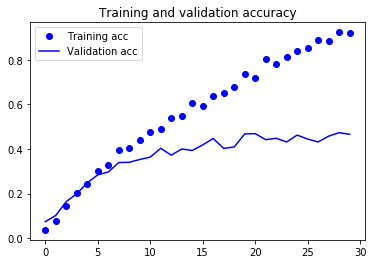

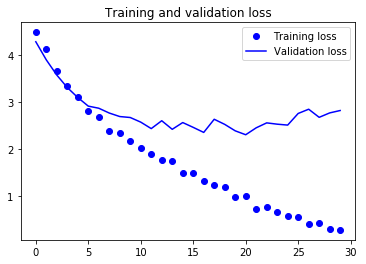

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The training accuracy increases linearly over time, until it reaches nearly 100%, while our 
validation accuracy stalls at 40%. Our validation loss reaches its minimum after only five epochs then stalls, while the training loss 
keeps decreasing linearly until it reaches nearly 0.

Because we only have relatively few training samples, overfitting is going to be our number one concern. Could try 
number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). Lets try 
a technique used almost universally when processing images with deep learning models: *data 
augmentation*.

## Using data augmentation

Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data. 
Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit. Data 
augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number 
of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same 
picture twice. This helps the model get exposed to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our `ImageDataGenerator` 
instance.

In [40]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These options are:

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures 
vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal 
asymmetry (e.g. real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images:

In [41]:
#gives the path of every folder in the train folder
fnames = [os.path.join(train_dir, fname) for fname in os.listdir(train_dir)]
#fnames

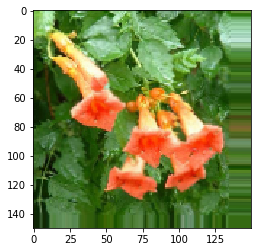

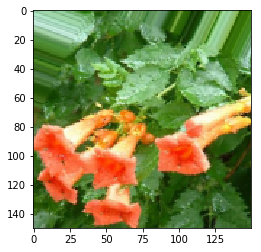

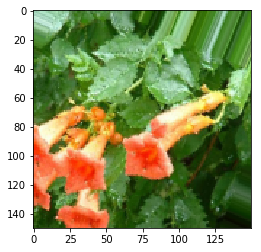

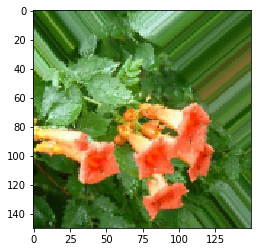

In [42]:
#pick one image to augment
img_path = fnames[3]

#read the img and re-size
img = image.load_img('D:\\ml_code\\keras\\flower_data\\train\\101\\image_07942.jpg',target_size=(150,150))

#convert to numpy array
x = image.img_to_array(img)

#reshape to (1,150,150,3)
x = x.reshape((1,)+x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()


If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs 
that it sees are still heavily intercorrelated, since they come from a small number of original images -- we cannot produce new information, 
we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting. To further fight 
overfitting, we will also add a Dropout layer to our model, right before the densely-connected classifier:

In [43]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(300, 300, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(102, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 33, 33, 128)       147584    
__________

train network using data augmentation and dropout:

In [45]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(300, 300),
        #No. of images to be yielded from the generator per batch
        color_mode = 'rgb',
        batch_size=40,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(300, 300),
        color_mode = 'rgb',
        batch_size=40,
        class_mode='categorical')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=70,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Found 6552 images belonging to 102 classes.
Found 818 images belonging to 102 classes.
Epoch 1/30
70/70 [==============================] - 76s 1s/step - loss: 4.4237 - acc: 0.0454 - val_loss: 4.2019 - val_acc: 0.0782
Epoch 2/30
70/70 [==============================] - 67s 958ms/step - loss: 4.0615 - acc: 0.0765 - val_loss: 3.8860 - val_acc: 0.1048
Epoch 3/30
70/70 [==============================] - 68s 971ms/step - loss: 3.8117 - acc: 0.1018 - val_loss: 3.6157 - val_acc: 0.1391
Epoch 4/30
70/70 [==============================] - 68s 964ms/step - loss: 3.6023 - acc: 0.1388 - val_loss: 3.5237 - val_acc: 0.1656
Epoch 5/30
70/70 [==============================] - 68s 966ms/step - loss: 3.4687 - acc: 0.1682 - val_loss: 3.2592 - val_acc: 0.2030
Epoch 6/30
70/70 [==============================] - 67s 964ms/step - loss: 3.3144 - acc: 0.1876 - val_loss: 3.1325 - val_acc: 0.2459
Epoch 7/30
70/70 [==============================] - 65s 924ms/step - loss: 3.2292 - acc: 0.2043 - val_loss: 3.0278 - v

In [46]:
model.save('flowers_small_2_2.h5')

Plot the results again

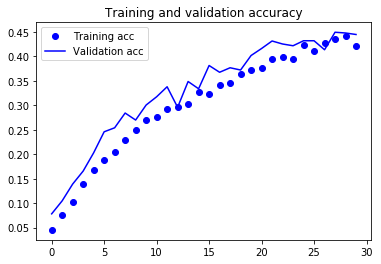

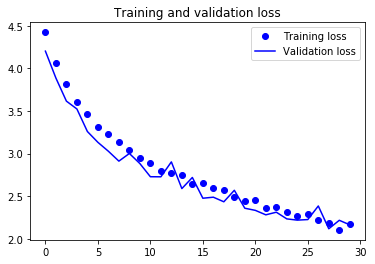

In [47]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Thanks to data augmentation and dropout, we are no longer overfitting: the training curves are rather closely tracking the validation 
curves. However there has been little relative improvement over the non-regularized model.

This work is continued on my next notebook